# Random Forest Regressor

- **랜덤포레스트(Random Forest)** 는 **Bagging**기반의 앙상블 기법중 하나로, **Boostrap Sampling**을 통해 여러개의 의사결정나무(베이스모델)를 생성한 후에 다수결 또는 평균에 따라 출력변수를 예측함
    - **Bootstrap Sampling** : 학습 데이터로부터 원하는 크기의 샘플을 복원추출하여 샘플데이터를 구축하는 방법
    - **Bagging** : Boostrap Aggregating의 약자로, Bootstrap Sampling을 통해 여러개의 표본을 만들고, 각 표본으로부터 베이스 모델을 형성하여 이를 결합하는 앙상블 기법
  
- 붓스트램 샘플링 뿐만아니라, **무작위 변수선택 기법**을 사용하여 의사결정나무의 다양성을 확보 한다.
- **변수의 중요도**를 파악 할 수 있기때문에 공정에서 혐의인자 관리용으로 유용하게 사용 가능한 앙상블 기법


### 1. 데이터 로드 및 전처리

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib
#한글꺠짐 방지
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
data=pd.read_csv("./data/Fault_data.csv",encoding="EUC-KR")
data.drop(["자재구분","END_DATE_TIME"],axis=1,inplace=True)
data.dropna(axis=1,inplace=True)

#X,Y 분할
Y=data["Y"].copy()
X=data.drop("Y",axis=1)
X.head(3)

,CHAMBER,TAE.STDDEV0,TAE.MEAN0,TAE.RANGE0,PC.STDDEV0,PC.MEAN0,PC.RANGE0,CROT.STDDEV0,CROT.MEAN0,CROT.RANGE0,...,PC.RANGE12,TAE.STDDEV9,TAE.MEAN9,TAE.RANGE9,CROT.STDDEV9,CROT.MEAN9,CROT.RANGE9,PC.STDDEV9,PC.MEAN9,PC.RANGE9
0,4,0.044554,38.083127,0.254154,0.124753,0.044329,0.439883,0,35,0,...,17.350926,0.032832,35.011650,0.127077,0,35,0,0.405343,45.124841,3.079182
1,2,0.034801,38.052395,0.063538,0.177575,0.342131,0.439883,0,27,0,...,1.466280,0.020858,35.550245,0.063540,0,27,0,1.923012,45.350277,15.004887
2,3,0.030089,38.046407,0.127080,0.137559,0.063983,0.488759,0,15,0,...,13.098728,0.021635,36.013373,0.063538,0,15,0,0.161640,45.071393,0.977516


### 2. 평가 지표 함수

In [4]:
# 평가 지표 출력 함수
def print_all_reg(Y_test,pred):
    print("model의 MSE 값은 {:.3f}".format(mean_squared_error(Y_test,pred)))
    print("model의 MAE 값은 {:.3f}".format(mean_absolute_error(Y_test, pred)))
    print("model의 MAPE 값은 {:.3f}".format(mean_absolute_percentage_error(Y_test, pred)))
    print("model의 r2 값은 {:.3f}".format(r2_score(Y_test, pred)))

### 3. 모델 학습 및 예측

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=38,shuffle =True)

[[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)]  
**sklearn.model_selection.train_test_split**
- **test_size** : float or int, default = 0.25, 정수값일시 test사이즈로 설정하고 싶은 샘플 수 입력
- **train_size** : float or int, default = None
- **random_state** : int, default = None, 랜덤 seed값 설정, 같은 seed 내에선 동일결과 추출 
- **shuffle** : bool, default = True, 데이터셋 무작위 추출, 시계열 데이터와 같이 순차적 추출이 필요한 경우엔 Shuffle = False!
- **stratify** : array-like, default = None, True일시 계층적 샘플링 진행 ([참고](https://www.investopedia.com/terms/stratified_random_sampling.asp))

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 데이터 전처리 및 랜덤포레스트 모델 학습과정을 자동화 하는 함수
def auto_randomforest(data_x,data_y,model,scaler_how,params):
    
    # 데이터 split
    split_num = 5 # k값 설정
    kfold = KFold(n_splits=split_num, shuffle=True, random_state=10) # K-fold 교차검증 적용
    score = []
    for train_index,test_index in kfold.split(data_x):
        train_x,valid_x = data_x.iloc[train_index],data_x.iloc[test_index]  # data_x를 훈련용, 검증용 데이터셋으로 분할
        train_y,valid_y = data_y.iloc[train_index],data_y.iloc[test_index]  # data_y를 훈련용, 검증용 데이터셋으로 분할
        
        # 1 .model select 
        if model == "rf":
            
            #2. params를 통해 하이퍼 파라미터 세팅
            model_use = RandomForestRegressor(random_state=0, n_estimators = params['n_estimators'],
                                               max_depth = params["max_depth"],min_samples_leaf = params["min_samples_leaf"],
                                               min_samples_split = params["min_samples_split"]
                                              )      
        else:
            print("모델이 존재하지 않습니다.")
            break
        
        # 3. Scaling 
        if scaler_how == "minmax":
            print("minmax")
            scaler = MinMaxScaler()
            train_x = scaler.fit_transform(train_x) # 훈련용 데이터 MinMax Scaler 학습
            valid_x = scaler.transform(valid_x) # 앞서 학습한 Scaler로 검증용 데이터 스케일링, 검증 데이터셋에는 fit_transform 하지 않도록 주의
        elif scaler_how == "zscore":
            print("z변환")
            scaler2 = StandardScaler()
            train_x = scaler2.fit_transform(train_x)# 훈련용 데이터 Standard Scaler 학습
            valid_x = scaler2.transform(valid_x) # 앞서 학습한 Scaler로 검증용 데이터 스케일링, 검증 데이터셋에는 fit_transform 하지 않도록 주의           
        else:
            print("해당하는 스케일러가 없습니다.")
            #print("스케일링 변환 X")
            
        # 4. FIT & TEST
        model_use.fit(train_x, train_y) # 훈련용 데이터로 랜덤포레스트 모델 학습
        valid_pred = model_use.predict(valid_x) # 학습한 모델에 검증데이터셋을 넣어 예측값 생성
        tem = mean_absolute_error(valid_pred,valid_y) # 검증 데이터셋을 활용하여 모델 성능 평가
        score.append(tem) # 결과 저장, 해당 과정을 k번 반복
    total_score = np.mean(score) # k번 검증된 결과의 평균 출력
    print("%s 모델 K-fold 결과 f1_score: %f "%(model,total_score))

    return total_score


In [10]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# 원하는 파라미터 설정 (파라미터를 추가하려면 위의 함수에도 추가해줘야함.)
params={
    "n_estimators":[500,1000],
    "max_depth":[4,6,8,10],
    "min_samples_leaf" : [2, 4, 6],
    "min_samples_split" : range(2,8,2)
}

# ParameterGrid 통해서 모든 경우의 수 만들기 
params_list = list(ParameterGrid(params)) # 총 72가지 경우의수가 담긴 리스트 반환

# grid search 진행
score_list = []
for params2 in params_list:
    tem = auto_randomforest(X_train,Y_train,'rf',"zscore",params2) # 데이터셋에 StandardScaler를 적용하여 랜덤포레스트 모델 학습
    score_list.append(tem)

# BEST SCORE 계산
best_index= np.argmax(score_list)
print("BEST SCORE", score_list[best_index])
print("BEST PARAMS", params_list[best_index])

z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 34.622759 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 34.404316 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 34.622759 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 34.404316 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 34.513042 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 34.359548 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.013029 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.138940 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.013029 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.138940 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.013029 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.138940 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.750130 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.772740 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.750130 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.772740 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fold 결과 f1_score: 35.750130 
z변환
z변환
z변환
z변환
z변환
rf 모델 K-fol

In [12]:
from sklearn.ensemble import RandomForestRegressor

# 최적의 하이퍼파라미터로 모델 학습
clf=RandomForestRegressor(random_state=5, n_estimators = 1000,
                                               max_depth = 8,min_samples_leaf = 6,
                                               min_samples_split = 2
                                              )   
clf.fit(X_train,Y_train)
preds = clf.predict(X_test)
preds_train = clf.predict(X_train)
print_all_reg(Y_train,preds_train)
print("")
print_all_reg(Y_test,preds)

model의 MSE 값은 1331.784
model의 MAE 값은 23.173
model의 MAPE 값은 0.623
model의 r2 값은 0.666

model의 MSE 값은 2065.891
model의 MAE 값은 28.754
model의 MAPE 값은 0.730
model의 r2 값은 0.492


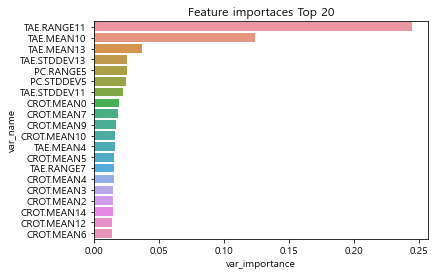

In [14]:
#주요 변수 확인
import matplotlib.pyplot as plt
import seaborn as sns
var_imp = pd.DataFrame({'var_name':X.columns , 'var_importance': clf.feature_importances_}) # 변수명과 해당 변수의 중요도 값을 데이터프레임 형태로 생성
imp_top20=var_imp.sort_values(by=['var_importance'],ascending=False)[:20] # 결과값 내림차순 정렬
imp_top20.head(n=10) # 상위 10개변수만 출력
plt.figure
plt.title("Feature importaces Top 20")
sns.barplot(x=imp_top20["var_importance"], y=imp_top20["var_name"])
plt.show()